In [30]:
import os
import time
import uuid
import cv2

In [31]:
IMAGES_PATH = 'data'
number_images = 10

In [32]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### Create Dataset

In [33]:
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

In [34]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [35]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [36]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath) 

### Image Augmentation

In [37]:
import albumentations as alb

In [38]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                        keypoint_params=alb.KeypointParams(format='xy', label_fields=['class_labels']))

In [39]:
for partition in ['train', 'test', 'val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        classes = [0,0]
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
    
            if label['shapes'][0]['label']=='LeftEye': 
                classes[0] = 1
                coords[0] = np.squeeze(label['shapes'][0]['points'])[0]
                coords[1] = np.squeeze(label['shapes'][0]['points'])[1]

            if label['shapes'][0]['label']=='RightEye':
                classes[1] = 1
                coords[2] = np.squeeze(label['shapes'][0]['points'])[0]
                coords[3] = np.squeeze(label['shapes'][0]['points'])[1]

            if len(label['shapes']) > 1:     
                if label['shapes'][1]['label'] =='LeftEye': 
                    classes[0] = 1 
                    coords[0] = np.squeeze(label['shapes'][1]['points'])[0]
                    coords[1] = np.squeeze(label['shapes'][1]['points'])[1]

                if label['shapes'][1]['label'] =='RightEye': 
                    classes[1] = 1
                    coords[2] = np.squeeze(label['shapes'][1]['points'])[0]
                    coords[3] = np.squeeze(label['shapes'][1]['points'])[1]
            
            np.divide(coords, [640,480,640,480])
                
        try: 
            for x in range(120):
                keypoints = [(coords[:2]), (coords[2:])]
                augmented = augmentor(image=img, keypoints=keypoints, class_labels=['LeftEye','RightEye'])
                cv2.imwrite(os.path.join('data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image
                annotation['class'] = [0,0]
                annotation['keypoints'] = [0,0,0,0]

                if os.path.exists(label_path):
                    if len(augmented['keypoints']) > 0: 
                        for idx, cl in enumerate(augmented['class_labels']):
                            if cl == 'LeftEye': 
                                annotation['class'][0] = 1 
                                annotation['keypoints'][0] = augmented['keypoints'][idx][0]
                                annotation['keypoints'][1] = augmented['keypoints'][idx][1]
                            if cl == 'RightEye': 
                                annotation['class'][1] = 1 
                                annotation['keypoints'][2] = augmented['keypoints'][idx][0]
                                annotation['keypoints'][3] = augmented['keypoints'][idx][1]
                                
                annotation['keypoints'] = list(np.divide(annotation['keypoints'], [450,450,450,450]))


                with open(os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

Expected x for keypoint (723.9534883720931, 374.30232558139534, 0.0, 0.0, 'LeftEye') to be in the range [0.0, 450], got 723.9534883720931.
Expected x for keypoint (767.6388888888889, 368.4722222222223, 0.0, 0.0, 'LeftEye') to be in the range [0.0, 450], got 767.6388888888889.
Expected x for keypoint (787.0833333333333, 369.86111111111114, 0.0, 0.0, 'LeftEye') to be in the range [0.0, 450], got 787.0833333333333.
Expected x for keypoint (870.4166666666666, 376.8055555555556, 0.0, 0.0, 'LeftEye') to be in the range [0.0, 450], got 870.4166666666666.
Expected x for keypoint (716.25, 378.1944444444445, 0.0, 0.0, 'LeftEye') to be in the range [0.0, 450], got 716.25.
Expected x for keypoint (625.9722222222222, 455.97222222222223, 0.0, 0.0, 'LeftEye') to be in the range [0.0, 450], got 625.9722222222222.
Expected x for keypoint (953.75, 471.25000000000006, 0.0, 0.0, 'LeftEye') to be in the range [0.0, 450], got 953.75.
Expected x for keypoint (732.1827956989247, 414.43548387096774, 0.0, 0.0, 

# Detection

In [40]:
import os
import cv2
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

In [41]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

### Load Images

In [42]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

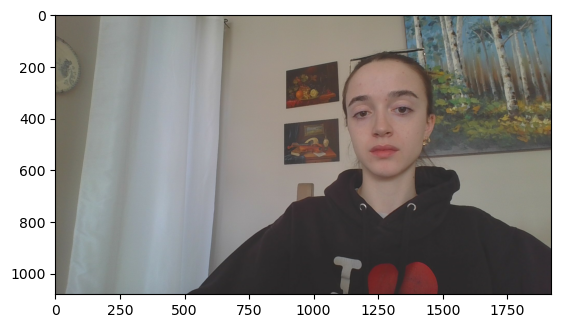

In [58]:
train_images = tf.data.Dataset.list_files('data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
plt.imshow(train_images.as_numpy_iterator().next())
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250))) #reducing data to parse through after
train_images = train_images.map(lambda x: x/255) # normalized image to be represented by values between 0-1 rather than 0-255

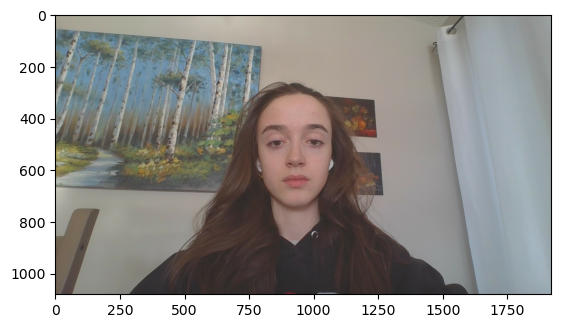

In [59]:
test_images = tf.data.Dataset.list_files('data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
plt.imshow(test_images.as_numpy_iterator().next())
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

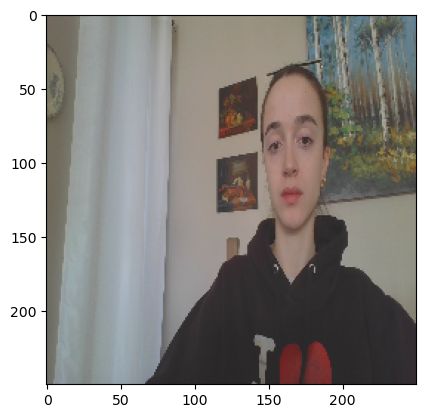

In [60]:
val_images = tf.data.Dataset.list_files('data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
plt.imshow(train_images.as_numpy_iterator().next())
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

### Load Labels

In [63]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['keypoints']]

In [64]:
train_labels = tf.data.Dataset.list_files('data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [65]:
# First 2: [X-Left Eye, Y-Left Eye]a
# Second 2: [X-Right Eye, Y-Right Eye]

In [48]:
test_labels = tf.data.Dataset.list_files('data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [49]:
val_labels = tf.data.Dataset.list_files('data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

### Combining Labels and Images

In [50]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(16)
train = train.prefetch(4)

In [51]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(16)
test = test.prefetch(4)

In [52]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(16)
val = val.prefetch(4)

### Viewing Samples

In [53]:
data_samples = train.as_numpy_iterator()

In [54]:
res = data_samples.next()

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} KeyError: 'keypoints'
Traceback (most recent call last):

  File "C:\Users\berse\anaconda3\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 268, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\berse\anaconda3\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 146, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\berse\anaconda3\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 153, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "C:\Users\berse\anaconda3\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\berse\AppData\Local\Temp\ipykernel_18980\2821726087.py", line 4, in load_labels
    return [label['keypoints']]
            ~~~~~^^^^^^^^^^^^^

KeyError: 'keypoints'


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

# Building Model
### Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2

In [ ]:
# TO BE MODIFIED
model = Sequential([
    Input(shape=(250,250,3)), 
    ResNet152V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Reshape((4,))
])

In [ ]:
model.summary()

### Losses and Optimizers

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [ ]:
model.compile(optimizer, loss)

### Sense Check Predictions

In [ ]:
X, y = train.as_numpy_iterator().next()

In [ ]:
X.shape

In [ ]:
scores = model.predict(X)

In [ ]:
scores

### Train

In [ ]:
# Train for 100 epochs
hist = model.fit(train, epochs=1, validation_data=val)

### Review Performance

#### Loss Plots

In [ ]:
hist.history

In [ ]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()